In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "C:/Users/USER/.keras/datasets/jena_climate_2009_2016.csv"

In [5]:
df = pd.read_csv(csv_path)
df = df[5: :6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

wv = df["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0


wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)
df["max Wx"] = max_wv * np.cos(wd_rad)
df["max Wy"] = max_wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df["Day sin"] = np.sin(timestamp_s * (2 * np.pi /day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi /day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

fft = tf.signal.rfft(df["T (degC)"])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df["T (degC)"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / (hours_per_year)
f_per_year = f_per_dataset / years_per_dataset

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [15]:
input_width=6
label_width=1
shift=1


total_window_size = input_width + shift

input_slice = slice(0, input_width)
input_indices = np.arange(total_window_size)[input_slice]

label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
label_indices = np.arange(total_window_size)[labels_slice]

print(np.arange(total_window_size))
print(np.arange(total_window_size)[input_slice])
print(np.arange(total_window_size)[labels_slice])

[0 1 2 3 4 5 6]
[0 1 2 3 4 5]
[6]


In [17]:
print(train_df[: total_window_size].shape)
print(train_df[100: 100 + total_window_size].shape)
print(train_df[200: 200 + total_window_size].shape)

(7, 19)
(7, 19)
(7, 19)


In [20]:
example_window = tf.stack([np.array(train_df[: total_window_size]),
         np.array(train_df[100: 100 + total_window_size]),
         np.array(train_df[200: 200 + total_window_size])])

example_window.shape

TensorShape([3, 7, 19])

## 3d slicing

In [24]:
example_window[:, :, :].shape

TensorShape([3, 7, 19])

In [25]:
# 3개 batch 중 0번 batch
example_window[0, :, :].shape

TensorShape([7, 19])

In [30]:
# 7개 timestep 중 0번 timestep
example_window[:, 0, :].shape

TensorShape([3, 19])

In [31]:
# 19개 feature 중 0번 val
example_window[:, :, 0].shape

<tf.Tensor: shape=(3, 7), dtype=float64, numpy=
array([[ 0.9453076 ,  0.95976985,  0.98628397,  1.00436178,  1.06100558,
         1.09113526,  1.16585687],
       [-0.37196209, -0.3237546 , -0.22492924, -0.11887276, -0.02848372,
         0.06913645,  0.15832031],
       [ 1.76724532,  1.83112024,  1.83353062,  1.76121938,  1.70337039,
         1.62985397,  1.62262285]])>

### labels

In [33]:
#example_window

In [41]:
example_window[:, slice(0, 6), :]

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [42]:
example_window[:, slice(6, None), :]

<tf.Tensor: shape=(3, 1, 19), dtype=float64, numpy=
array([[[ 1.16585687, -2.11187895, -2.18630526, -2.10829405,
          1.0264963 , -1.34053929, -1.55098787, -0.78419664,
         -1.55490762, -1.55781362,  2.41677711,  1.30882225,
         -0.00800171,  1.2110392 ,  0.05726148,  1.3661334 ,
         -0.36590717, -0.05491443,  1.42836033]],

       [[ 0.15832031, -1.46022873, -1.46536735, -1.39260223,
          0.77280166, -1.12480743, -1.23256645, -0.71985112,
         -1.22921766, -1.2338741 ,  1.46481946,  2.73699567,
          1.02038929,  2.75528419,  0.98525249,  0.36611056,
         -1.36586397,  0.04724135,  1.42330667]],

       [[ 1.62262285, -1.47871527, -1.59144552, -2.13411059,
         -0.96198639, -1.13130538, -1.56049298, -0.4437881 ,
         -1.56613831, -1.56955056,  1.88305579, -0.17285229,
         -0.04615311, -0.16000027, -0.00391417, -0.99994604,
         -0.99985438,  0.14876732,  1.41106077]]])>

In [45]:
labels = example_window[:, labels_slice, :]
labels

<tf.Tensor: shape=(3, 1, 19), dtype=float64, numpy=
array([[[ 1.16585687, -2.11187895, -2.18630526, -2.10829405,
          1.0264963 , -1.34053929, -1.55098787, -0.78419664,
         -1.55490762, -1.55781362,  2.41677711,  1.30882225,
         -0.00800171,  1.2110392 ,  0.05726148,  1.3661334 ,
         -0.36590717, -0.05491443,  1.42836033]],

       [[ 0.15832031, -1.46022873, -1.46536735, -1.39260223,
          0.77280166, -1.12480743, -1.23256645, -0.71985112,
         -1.22921766, -1.2338741 ,  1.46481946,  2.73699567,
          1.02038929,  2.75528419,  0.98525249,  0.36611056,
         -1.36586397,  0.04724135,  1.42330667]],

       [[ 1.62262285, -1.47871527, -1.59144552, -2.13411059,
         -0.96198639, -1.13130538, -1.56049298, -0.4437881 ,
         -1.56613831, -1.56955056,  1.88305579, -0.17285229,
         -0.04615311, -0.16000027, -0.00391417, -0.99994604,
         -0.99985438,  0.14876732,  1.41106077]]])>

In [59]:
labels[:, :, :]

<tf.Tensor: shape=(3, 1, 19), dtype=float64, numpy=
array([[[ 1.16585687, -2.11187895, -2.18630526, -2.10829405,
          1.0264963 , -1.34053929, -1.55098787, -0.78419664,
         -1.55490762, -1.55781362,  2.41677711,  1.30882225,
         -0.00800171,  1.2110392 ,  0.05726148,  1.3661334 ,
         -0.36590717, -0.05491443,  1.42836033]],

       [[ 0.15832031, -1.46022873, -1.46536735, -1.39260223,
          0.77280166, -1.12480743, -1.23256645, -0.71985112,
         -1.22921766, -1.2338741 ,  1.46481946,  2.73699567,
          1.02038929,  2.75528419,  0.98525249,  0.36611056,
         -1.36586397,  0.04724135,  1.42330667]],

       [[ 1.62262285, -1.47871527, -1.59144552, -2.13411059,
         -0.96198639, -1.13130538, -1.56049298, -0.4437881 ,
         -1.56613831, -1.56955056,  1.88305579, -0.17285229,
         -0.04615311, -0.16000027, -0.00391417, -0.99994604,
         -0.99985438,  0.14876732,  1.41106077]]])>

In [60]:
# T (deg C)의 index는 1이다.
column_indices

{'p (mbar)': 0,
 'T (degC)': 1,
 'Tpot (K)': 2,
 'Tdew (degC)': 3,
 'rh (%)': 4,
 'VPmax (mbar)': 5,
 'VPact (mbar)': 6,
 'VPdef (mbar)': 7,
 'sh (g/kg)': 8,
 'H2OC (mmol/mol)': 9,
 'rho (g/m**3)': 10,
 'Wx': 11,
 'Wy': 12,
 'max Wx': 13,
 'max Wy': 14,
 'Day sin': 15,
 'Day cos': 16,
 'Year sin': 17,
 'Year cos': 18}

In [54]:
# this one is NOT correct.
label_columns = ["T (degC)"]
[column_indices[name] for name in label_columns]

[1]

In [52]:
# this one is the correct feature-dimension integer index.
label_columns = "T (degC)"
column_indices[label_columns]

1

In [58]:
# thus:
labels[:, :, 1]

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-2.11187895],
       [-1.46022873],
       [-1.47871527]])>

In [57]:
# above tensor is same as the one below:
[labels[:, :, column_indices[name]] for name in label_columns] 

[<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[-2.11187895],
        [-1.46022873],
        [-1.47871527]])>]

In [62]:
# (1)
label_columns = ["T (degC)"]
tf.stack([labels[:, :, column_indices[name]] for name in label_columns])

<tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[-2.11187895],
        [-1.46022873],
        [-1.47871527]]])>

In [63]:
#(2)는 (1)과 다르다. 
tf.stack([labels[:, :, column_indices[name]] for name in label_columns], axis=-1)

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

In [68]:
labels = tf.stack([labels[:, :, column_indices[name]] for name in label_columns], axis=-1)

In [70]:
labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

- [tf.Tensor.set_shape](https://www.tensorflow.org/api_docs/python/tf/Tensor#set_shape)

In [73]:
print(labels.shape)
labels.set_shape([None, label_width, None])

(3, 1, 1)


In [74]:
labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

In [108]:
input_width = 6
label_width = 1
shift = 1
label_columns = ["T (degC)"]
total_window_size = input_width + shift
label_start = total_window_size - label_width
label_slice = slice(label_start, None)
labels = example_window[:, label_slice, :]
labels = tf.stack([labels[:, :, column_indices[name]] for name in label_columns], axis=-1)
labels.set_shape([None, label_width, None])
labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

### inputs

In [87]:
example_window[:, slice(0, 6), :]

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [89]:
input_width = 6
example_window[:, slice(0, input_width), :]

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [109]:
input_width = 6
input_slice = slice(0, input_width)
inputs = example_window[:, input_slice, :]
inputs.set_shape([None, input_width, None])
inputs

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

## example_window, inputs, labels
example_window에 split_window 적용하면 return되는 inputs, labels 이해하기
> inputs, labels는 example_inputs, example_labels에 assign 됨

In [110]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.95,-1.98,-2.04,-1.92,1.12,-1.30,-1.48,-0.79,-1.48,-1.48,2.22,0.19,0.22,0.11,0.22,0.37,1.37,-0.06,1.43
11,0.96,-2.08,-2.14,-2.06,1.04,-1.33,-1.53,-0.79,-1.54,-1.54,2.33,0.17,0.22,0.11,0.23,0.71,1.22,-0.06,1.43
17,0.99,-2.07,-2.13,-2.05,1.06,-1.33,-1.53,-0.79,-1.53,-1.53,2.32,0.21,0.28,0.11,0.32,1.00,1.00,-0.06,1.43
23,1.00,-2.10,-2.16,-2.10,1.01,-1.34,-1.55,-0.78,-1.55,-1.55,2.36,0.27,0.20,0.25,0.15,1.22,0.71,-0.06,1.43
29,1.06,-2.17,-2.23,-2.19,0.98,-1.35,-1.58,-0.78,-1.58,-1.59,2.45,0.11,0.35,0.05,0.40,1.37,0.37,-0.06,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294353,0.17,0.90,0.89,1.57,0.95,0.78,1.98,-0.49,1.98,1.98,-0.88,-0.17,-1.51,-0.16,-1.36,-0.96,1.04,-0.86,-1.15
294359,0.27,0.88,0.85,1.41,0.62,0.74,1.68,-0.28,1.67,1.67,-0.82,-0.82,-0.64,-0.70,-0.48,-0.65,1.25,-0.86,-1.15
294365,0.22,0.74,0.72,1.43,1.09,0.56,1.72,-0.61,1.71,1.71,-0.72,-0.03,0.65,0.01,0.60,-0.31,1.38,-0.86,-1.15
294371,0.21,0.71,0.69,1.41,1.15,0.52,1.69,-0.65,1.69,1.68,-0.69,0.01,-0.10,-0.10,-0.20,0.06,1.41,-0.86,-1.15


In [115]:
## example window
input_width = 6
shift = 1
total_window_width = input_width + shift

example_window = tf.stack([np.array(train_df[: total_window_width]), 
    np.array(train_df[100: 100 + total_window_width]),
    np.array(train_df[200: 200 + total_window_width])])

example_window

<tf.Tensor: shape=(3, 7, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [118]:
## inputs
input_slice = slice(0, input_width)
inputs = example_window[:, input_slice, :]
inputs.set_shape([None, input_width, None])
inputs

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [129]:
## labels
label_width = 1
label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
labels = example_window[:, label_slice, :]

column_indices = {name: i for i, name in enumerate(train_df.columns)}
label_columns = ["T (degC)"]
labels = tf.stack([labels[:, :, column_indices[name]] for name in label_columns], axis=-1)

labels.set_shape([None, label_width, None])
labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

In [136]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        #Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                         enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}
        
        #Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = self.input_width + self.shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

### window1
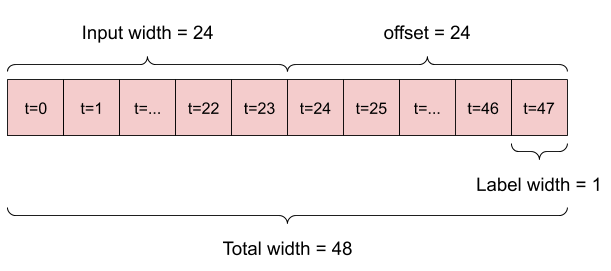

In [139]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
               label_columns=["T (degC)"])

w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

### window2
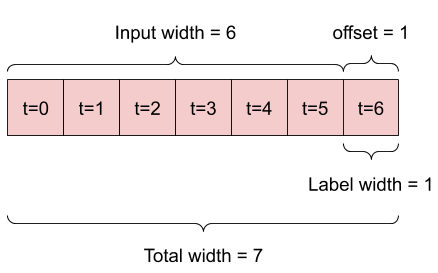

In [140]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
               label_columns=["T (degC)"])

w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### split_window
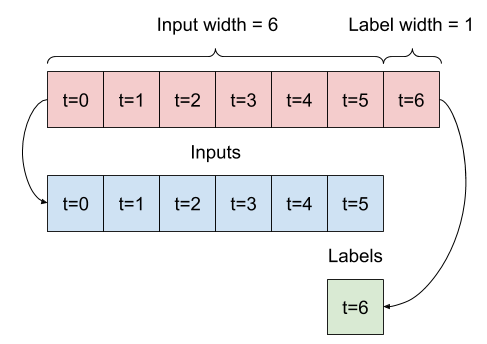

In [150]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, column_indices[name]] for name in label_columns],
                 axis=-1)
    
    # Slicing doesn;t preserve static shape information, so set the shapes
    # mannually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

Try it(`split_window`) out:

In [154]:
# Stack three slices, the length of the toal window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
    np.array(train_df[100: 100+total_window_size]),
    np.array(train_df[200: 200+total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [157]:
w2.example = example_inputs, example_labels # w2.split_window(example_window)

In [159]:
w2.example

(<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
 array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
          -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
          -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
          -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
           2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
           3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
           1.42843408e+00],
         [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
          -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
          -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
          -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
           2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
           7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
           1.42842359e+00],
         [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
          -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
          -1.52722507e+00, -7.8834796